# Entorno de simulación MEEP (MIT)



Acabada esta primera celda el entorno se reinicia.

In [ ]:
# Step 1: Install CondaColab
!pip install -q condacolab
import condacolab
condacolab.install()

# Step 2: Install necessary libraries using mamba (improved package manager for conda)
!conda install -y -c conda-forge mamba

# Step 3: Install Meep and dependencies in the base environment
!mamba install -y -c conda-forge pymeep=*=mpi_mpich_* nlopt

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    archspec-0.2.3             |     pyhd8ed1ab_0          48 KB  conda-forge
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.5.0               |  py310hff52083_0         939 KB  conda-forge
    fmt-10.2.1                 |       h00ab1b0_0         189 KB  conda-forge
    frozendict-2.4.4           |  py310hc51659f_0    

Parámetros generales

In [ ]:
# Verify Meep installation
!python -c "import meep as mp; print(mp.__version__)"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'meep'


In [ ]:

import meep as mp


import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define simulation parameters
resolution = 10# pixels/um

# Frequency range

f_min = 0.249# in  (meep units) (corresponding to 1550 nm)  a/lambda
f_max = 0.251# in  (corresponding to 1533 nm) a/lambda
n_frequencies = 1

# Material parameters
epsilon = 11.7 # index of refraction for waveguide (SiGe 75%)
wvg_thickness = 0.3# thickness of waveguide in um
wvg_width = 0.1 # width of waveguide in um
grating_period = 0.3 # period of grating in um
grating_duty_cycle = 0.4 # duty cycle of grating
grating_depth = 0.2  # depth of grating in um
grating_length = 20  # total length of grating region in um

# Simulation domain parameters
dpml = 0.2 # PML thickness
sx = 2*dpml + grating_length + 40 # total length of simulation domain in x
sy = 2*dpml + wvg_width  + 5   # total width of simulation domain in y
sz = 2*dpml + wvg_thickness + 4# total height of simulation domain in z



cell = mp.Vector3(sx, sy, sz)

# PML layers
pml_layers = [mp.PML(dpml)]

gold_plasma_freq = 1.37e15  # Plasma frequency of gold in rad/s
gold_gamma = 7.32e12        # Collision frequency of gold in rad/s

gold_material = mp.Medium(
    epsilon=1.0,  # Assumes gold is in vacuum (free space)
    E_susceptibilities=[mp.DrudeSusceptibility(frequency=gold_plasma_freq, gamma=gold_gamma)]
)

sio2_material = mp.Medium(epsilon=3.55)

Geometria (Se puede definir con un programa externo que compile formas a GDSII)

In [ ]:
# Geometry
geometry = [
    mp.Block(
        size=mp.Vector3(20, wvg_width, wvg_thickness),
        center=mp.Vector3(-10-grating_length/2,0,0),
        material=mp.Medium(epsilon = epsilon),
    ),

    mp.Block(
        size=mp.Vector3(grating_length, wvg_width, wvg_thickness),
        center=mp.Vector3(0,0,0),
        material=mp.Medium(epsilon=epsilon),
    ),
    mp.Block(
        size=mp.Vector3(20, wvg_width , wvg_thickness),
        center=mp.Vector3(10+grating_length/2,0,0),
        material=mp.Medium(epsilon=epsilon),
    ),
    mp.Block(
        size=mp.Vector3(grating_length+40, wvg_width+3, 1),
        center=mp.Vector3(0,0,-wvg_thickness/2-0.5),
        material=mp.Medium(epsilon=epsilon),
    ),
    mp.Block(
        size=mp.Vector3(grating_length+40, wvg_width+3,2),
        center=mp.Vector3(0,0,-wvg_thickness/2-2),
        material=sio2_material,
    ),


]

symmetry = [mp.Mirror(direction=mp.Y, phase=1)]

Análisis de resonancia del modo fundamental de la estructura. Si se trata de un dispositivo de audio, queremos excitar siempre el modo fundamental si se trata de una guía, ya que nos proporciona la menor distorsión del señal y una coherencia mayor en frecuéncia. En esta simulacion podemos observar los parametros S del dispositivo, con algunos efectos cuánticos superpuestos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Simulation parameters
resolution = 30  # Simulation resolution


# Gaussian source parameters
center_frequency = 0.25  # Center frequency of the Gaussian source (arbitrary value for example)
frequency_width = 0.001  # Width of the Gaussian spectrum

# Calculate the proportionality constant k0 based on the dispersion slope D
D = 0.49  # dispersion slope

# Define the Gaussian source with the specified frequency width
sources = [
    mp.EigenModeSource(mp.GaussianSource(frequency=center_frequency, fwidth=frequency_width),
                       center=mp.Vector3(-10-grating_length/2, 0, 0),
                       size=mp.Vector3(0, wvg_width, wvg_thickness),
                       eig_band=2,
                       eig_kpoint=mp.Vector3(0.8, 0, 0),
                       eig_match_freq=True)
]

# Initialize lists to store results
frequencies = []
incident_power_flux = []
transmitted_power_flux = []
reflected_power_flux = []

# Initialize the simulation
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=symmetry,
                    default_material=mp.Medium(epsilon=1))

# Define power flux monitors at the desired points for transmission and reflection
transmitted_monitor = sim.add_flux(center_frequency, frequency_width, 10000,
                                   mp.FluxRegion(center=mp.Vector3(0.5 * grating_length, 0, 0),
                                                 size=mp.Vector3(0, wvg_width, wvg_thickness)))

reflected_monitor = sim.add_flux(center_frequency, frequency_width, 10000,
                                 mp.FluxRegion(center=mp.Vector3(-0.5 * grating_length, 0, 0),
                                               size=mp.Vector3(0, wvg_width, wvg_thickness)))

# Calculate the incident flux spectrum
incident_monitor = sim.add_flux(center_frequency, frequency_width, 10000,
                                mp.FluxRegion(center=mp.Vector3(-5 - grating_length / 2, 0, 0),
                                              size=mp.Vector3(0, wvg_width, wvg_thickness)))

# Run the simulation
sim.run(until=500)

# Retrieve the power flux data
incident_flux_spectrum = np.array(mp.get_fluxes(incident_monitor))
transmitted_flux_spectrum = np.array(mp.get_fluxes(transmitted_monitor))
reflected_flux_spectrum = np.array(mp.get_fluxes(reflected_monitor))

# Calculate real source power (incident power)
incident_power = np.trapz(incident_flux_spectrum, x=mp.get_flux_freqs(incident_monitor))

# Calculate S-parameters (amplitude and phase)
freqs = np.array(mp.get_flux_freqs(incident_monitor))
guide_length = 10  # assume the guide length is 10 Meep distance units
k0 = freqs/D
phase_shift = k0 * guide_length  # calculate phase shift for each frequency

s11_amp = np.sqrt(reflected_flux_spectrum / incident_flux_spectrum)
s11_phase = np.angle(reflected_flux_spectrum / incident_flux_spectrum) - phase_shift
s21_amp = np.sqrt(transmitted_flux_spectrum / incident_flux_spectrum)
s21_phase = np.angle(transmitted_flux_spectrum / incident_flux_spectrum) - phase_shift

# Unwrap and wrap phase angles to [-180, 180] range
s11_phase = np.rad2deg(np.unwrap(s11_phase))
s21_phase = np.rad2deg(np.unwrap(s21_phase))

s11_phase = (s11_phase + 180) % 360 - 180
s21_phase = (s21_phase + 180) % 360 - 180

# Save S-parameters to CSV file
with open('s_parameters.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frequency (Hz)', 'S11 (Amplitude)', 'S11 (Phase)', 'S21 (Amplitude)', 'S21 (Phase)'])
    for f, r_amp, r_phase, t_amp, t_phase in zip(freqs, s11_amp, s11_phase, s21_amp, s21_phase):
        csvwriter.writerow([f, r_amp, r_phase, t_amp, t_phase])

# Plotting the S-parameters (amplitude and phase)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freqs, s11_amp, label='S11 (Reflection)')
plt.plot(freqs, s21_amp, label='S21 (Transmission)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('S-Parameters')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(freqs, s11_phase, label='S11 (Reflection)')
plt.plot(freqs, s21_phase, label='S21 (Transmission)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (deg)')
plt.title('S-Parameters')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00582191 s
Working in 3D dimensions.
Computational cell is 60.4 x 5.5 x 4.7 with resolution 30
     block, center = (-20,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7,11.7,11.7)
     block, center = (0,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7,11.7,11.7)
     block, center = (20,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7,11.7,11.7)
     block, center = (0,0,-0.65)
          size (60,3.1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7,11.7,11.7)
     block, center = (0,0,-2.15)
          size (60,3.1,2)
          axes (1,0,0), (0,

FloatProgress(value=0.0, description='0% done ', max=500.0)

Meep progress: 0.016666666666666666/500.0 = 0.0% done in 43.4s, 1300870.0s to go
on time step 1 (time=0.0166667), 43.3586 s/step
Meep progress: 0.13333333333333333/500.0 = 0.0% done in 47.6s, 178626.4s to go
on time step 8 (time=0.133333), 0.611097 s/step
Meep progress: 0.23333333333333334/500.0 = 0.0% done in 51.8s, 110886.1s to go
on time step 14 (time=0.233333), 0.687079 s/step
Meep progress: 0.35/500.0 = 0.1% done in 56.3s, 80375.0s to go
on time step 21 (time=0.35), 0.646609 s/step
Meep progress: 0.4666666666666667/500.0 = 0.1% done in 60.6s, 64820.9s to go
on time step 28 (time=0.466667), 0.607264 s/step
Meep progress: 0.5833333333333334/500.0 = 0.1% done in 65.1s, 55764.3s to go
on time step 35 (time=0.583333), 0.653622 s/step
Meep progress: 0.6833333333333333/500.0 = 0.1% done in 69.2s, 50590.4s to go
on time step 41 (time=0.683333), 0.682986 s/step
Meep progress: 0.7833333333333333/500.0 = 0.2% done in 73.6s, 46917.7s to go
on time step 47 (time=0.783333), 0.730385 s/step
Meep

Replot settings

In [ ]:

# Prepare data for plotting
x_data = []
y_data = []
color_data = []
for i in range(num_points):
    x_point = [gaussian_freqs[i]] * len(resonant_freqs[i*num_points:(i+1)*num_points])
    y_point = resonant_freqs[i*num_points:(i+1)*num_points]
    color_point = amplitudes[i*num_points:(i+1)*num_points]
    x_data.extend(x_point)
    y_data.extend(y_point)
    color_data.extend(color_point)

# Convert lists to numpy arrays for plotting
x_data = np.array(x_data)
y_data = np.array(y_data)
color_data = np.array(color_data)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_data, y_data, c=color_data, cmap='plasma', marker='o')
plt.colorbar(scatter, label='Amplitude')
plt.xlabel('Gaussian Frequency (Hz)')
plt.ylabel('Resonant Frequency (Hz)')
plt.title('Gaussian Frequency vs. Resonant Frequency and Amplitude')
plt.grid(True)
plt.show()

# Print filtered results for inspection
for i, freq in enumerate(gaussian_freqs):
    print(f"Gaussian Frequency = {freq:.6f} Hz, Resonant Frequencies = {resonant_freqs[i*num_points:(i+1)*num_points]}, Amplitudes = {amplitudes[i*num_points:(i+1)*num_points]}")

NameError: name 'gaussian_freqs' is not defined

Estructura de bandas de la guía. Podemos identificar los modos si miramos k=0 (punto gamma)

Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 60 x 60 x 60.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-20,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (20,0,0)
          size (20,0.1,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.65)
          size (60,3.1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2.15)
          size (60,3.1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 30 object nodes (vs. 5 actual objects)
Initializing epsilon function...
Allocating fields

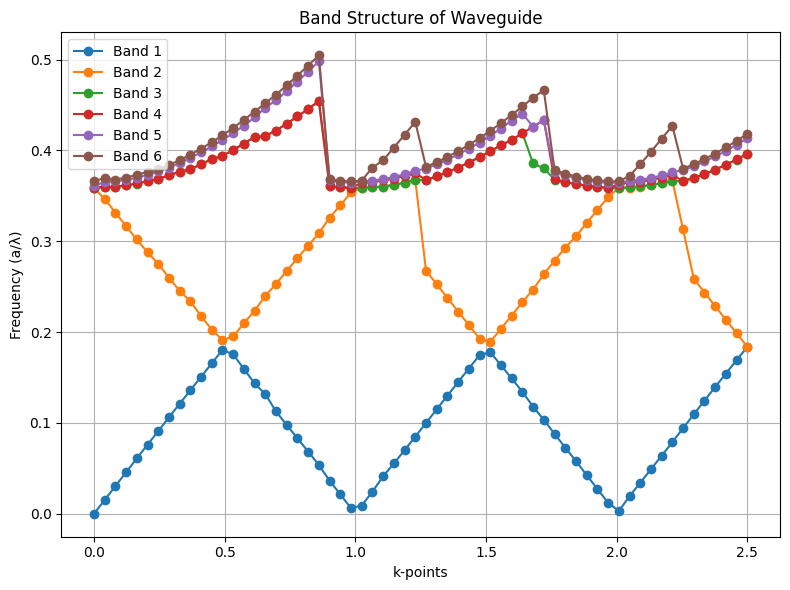

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from meep import mpb


# Assuming 'geometry' is defined elsewhere for your waveguide structure



num_points = 60  # Number of points in the wavelength range

# Compute the corresponding k-values
k_min = 0
k_max = 2.5

# Set up k-points using interpolation
k_points = mp.interpolate(num_points, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Mode solver setup
mode_solver = mpb.ModeSolver(
    geometry=geometry,
    resolution=60,  # Higher resolution for better accuracy
    k_points=k_points,  # Adjusted k-points covering the desired k-range

    num_bands=6,  # Number of bands (modes) to compute
)

# Run the mode solver for TE modes
mode_solver.run_te()

mode_solver.display_eigensolver_stats()

# Retrieve eigenfrequencies for each band
eigenfrequencies = mode_solver.all_freqs

# Extract k-points for plotting
k_values = [kp.x for kp in k_points]

# Plotting the band diagram for the wavelength range
plt.figure(figsize=(8, 6))

# Plot each band's eigenfrequencies against k-points
for band in range(len(eigenfrequencies[0])):
    plt.plot(k_values, [eigenfrequencies[i][band] for i in range(len(k_values))], marker='o', linestyle='-', label=f'Band {band+1}')

plt.xlabel('k-points')
plt.ylabel('Frequency (a/λ)')
plt.title('Band Structure of Waveguide')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Definir la fuente y ajustar la simulación

En el siguiente codigo podemos previsualizar la estructura



In [ ]:
# Plot each band's eigenfrequencies against k-points
for band in range(len(eigenfrequencies[0])):
    plt.plot(k_values, [eigenfrequencies[i][band] for i in range(len(k_values))], marker='o', linestyle='-', label=f'Band {band+1}')

plt.xlabel('k-points')
plt.ylabel('Frequency (a/λ)')
plt.title('Band Structure of Waveguide')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'eigenfrequencies' is not defined

In [ ]:
!pip install pyvista

-----------
Initializing structure...
time for choose_chunkdivision = 0.000911429 s
Working in 3D dimensions.
Computational cell is 27 x 2.5 x 2.3 with resolution 10
     block, center = (-10,0,0)
          size (10,0.36,0.18)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,0)
          size (5,0.36,0.18)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (10,0,0)
          size (10,0.36,0.18)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-0.59)
          size (25,2.36,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.9,3.9,3.9)
time for set_epsilon = 1.16088 s
-----------


FloatProgress(value=0.0, description='0% done ', max=90.0)

run 0 finished at t = 90.0 (1800 timesteps)
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1

IndexError: index 25 is out of bounds for axis 1 with size 25

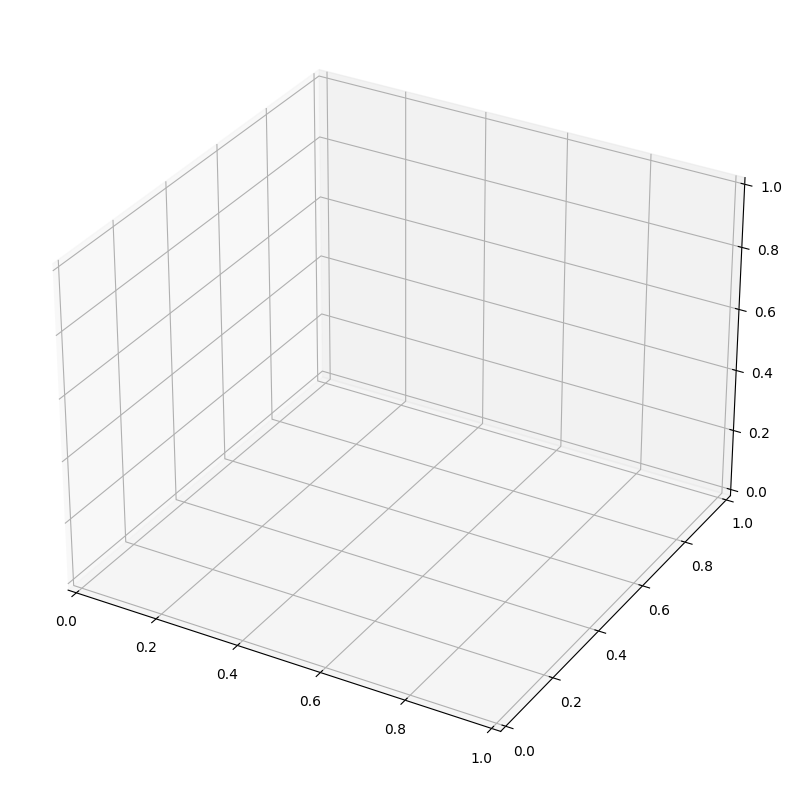

In [ ]:
# Sources
sources = [mp.EigenModeSource(
    src=mp.GaussianSource(frequency=f_min, width=0.0000043),
    size=mp.Vector3(0,wvg_width, wvg_thickness),
    center=mp.Vector3(-grating_length/2-4, 0, 0),
    eig_kpoint = mp.Vector3(0.78,0,0),
    eig_match_freq=True,
    eig_band=1,





    )]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=60,
    default_material=mp.Medium(epsilon=1),
    symmetries=symmetry,
    subpixel_tol=1e-2,
    subpixel_maxeval=1000,


)



# Frequency range
frequencies = np.linspace(f_min, f_max, n_frequencies)
transmissions = []
reflections = []

Ejecutar la simulacion

3D field

In [ ]:


# Define the function to run the simulation for a single frequency
def run_simulation(f):
    sim.reset_meep()
    sim.change_sources([mp.EigenModeSource(
         src=mp.ContinuousSource(frequency=f),
         size=mp.Vector3(0,wvg_width, wvg_thickness),
         center=mp.Vector3(-4-grating_length/2,0,0),

         eig_match_freq=True,
         eig_band=1,
         eig_kpoint = mp.Vector3(0.78,0,0),


    )])

    trans = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*grating_length,0,0), size=mp.Vector3(0,wvg_width,wvg_thickness)))
    refl = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*grating_length,0,0), size=mp.Vector3(0,wvg_width,wvg_thickness)))

    sim.run(until=150)

    trans_flux = mp.get_fluxes(trans)
    refl_flux = mp.get_fluxes(refl)

    # Extract the electric field components
    ex_data = sim.get_array(component=mp.Ex, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ey_data = sim.get_array(component=mp.Ey, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ez_data = sim.get_array(component=mp.Ez, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))

    # Extract the real part of the electric field components
    ex_real = np.real(ex_data)
    ey_real = np.real(ey_data)
    ez_real = np.real(ez_data)

    # Calculate the instantaneous total electric field at each point
    e_total_real = np.sqrt(ex_real**2 + ey_real**2 + ez_real**2)

    # Extract cross-sections
    xy_plane = e_total_real[:, :, int(sz)//2]
    xz_plane = e_total_real[:, int(sy)//2, :]
    yz_plane = e_total_real[int(sx)//2, :, :]

    return f, trans_flux[0], refl_flux[0], xy_plane, xz_plane, yz_plane

# Lists to store results
transmissions = []
reflections = []
field_data = []

3D poynting

In [ ]:


def run_simulation(f):
    sim.reset_meep()
    sim.change_sources([mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=f),
        size=mp.Vector3(0, wvg_width, wvg_thickness),
        center=mp.Vector3(-4 - grating_length / 2, 0, 0),
        eig_match_freq=True,
        eig_band=3,
        eig_kpoint=mp.Vector3(0.78, 0, 0),
    )])

    trans = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5 * grating_length, 0, 0), size=mp.Vector3(0, wvg_width, wvg_thickness)))
    refl = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5 * grating_length, 0, 0), size=mp.Vector3(0, wvg_width, wvg_thickness)))

    sim.run(until=350)

    trans_flux = mp.get_fluxes(trans)
    refl_flux = mp.get_fluxes(refl)

    # Retrieve E and H fields to compute the Poynting vector
    ex_data = sim.get_array(component=mp.Ex, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ey_data = sim.get_array(component=mp.Ey, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ez_data = sim.get_array(component=mp.Ez, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hx_data = sim.get_array(component=mp.Hx, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hy_data = sim.get_array(component=mp.Hy, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hz_data = sim.get_array(component=mp.Hz, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))

    # Calculate the Poynting vector components
    px_data = np.real(ey_data * np.conj(hz_data) - ez_data * np.conj(hy_data))
    py_data = np.real(ez_data * np.conj(hx_data) - ex_data * np.conj(hz_data))
    pz_data = np.real(ex_data * np.conj(hy_data) - ey_data * np.conj(hx_data))

    # Calculate the magnitude of the Poynting vector
    p_total = np.sqrt(px_data**2 + py_data**2 + pz_data**2)

    # Extract cross-sections
    xy_plane = p_total[:, :, int(sz) // 2]
    xz_plane = p_total[:, int(sy) // 2, :]
    yz_plane = p_total[int(sx) // 2, :, :]

    return f, trans_flux[0], refl_flux[0], xy_plane, xz_plane, yz_plane

# Lists to store results
transmissions = []
reflections = []
field_data = []

2D poynting

In [ ]:


def run_simulation(f):
    sim.reset_meep()
    sim.change_sources([mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=f),
        size=mp.Vector3(0, wvg_width, wvg_thickness),
        center=mp.Vector3(-4 - grating_length / 2, 0, 0),
        eig_match_freq=True,
        eig_band=3,
        eig_kpoint=mp.Vector3(0.78, 0, 0),
    )])

    trans = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5 * grating_length, 0, 0), size=mp.Vector3(0, wvg_width, wvg_thickness)))
    refl = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5 * grating_length, 0, 0), size=mp.Vector3(0, wvg_width, wvg_thickness)))

    sim.run(until=250)

    trans_flux = mp.get_fluxes(trans)
    refl_flux = mp.get_fluxes(refl)

    # Retrieve E and H fields to compute the Poynting vector
    ex_data = sim.get_array(component=mp.Ex, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ey_data = sim.get_array(component=mp.Ey, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ez_data = sim.get_array(component=mp.Ez, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hx_data = sim.get_array(component=mp.Hx, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hy_data = sim.get_array(component=mp.Hy, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    hz_data = sim.get_array(component=mp.Hz, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))

    # Calculate the Poynting vector components
    px_data = np.real(ey_data * np.conj(hz_data) - ez_data * np.conj(hy_data))
    py_data = np.real(ez_data * np.conj(hx_data) - ex_data * np.conj(hz_data))
    pz_data = np.real(ex_data * np.conj(hy_data) - ey_data * np.conj(hx_data))

    # Calculate the magnitude of the Poynting vector
    p_total = np.sqrt(px_data**2 + py_data**2 + pz_data**2)

    # Extract cross-sections
    xy_plane = p_total


    return f, trans_flux[0], refl_flux[0], xy_plane

# Lists to store results
transmissions = []
reflections = []
field_data = []

2D field

In [ ]:
# Define the function to run the simulation for a single frequency
def run_simulation(f):
    sim.reset_meep()
    sim.change_sources([mp.EigenModeSource(
         src=mp.ContinuousSource(frequency=f),
         size=mp.Vector3(0,wvg_width, wvg_thickness),
         center=mp.Vector3(-4-grating_length/2,0,0),

         eig_match_freq=True,
         eig_band=1,
         eig_kpoint = mp.Vector3(0.78,0,0),


    )])

    trans = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*grating_length,0,0), size=mp.Vector3(0,wvg_width,wvg_thickness)))
    refl = sim.add_flux(f, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*grating_length,0,0), size=mp.Vector3(0,wvg_width,wvg_thickness)))

    sim.run(until=250)

    trans_flux = mp.get_fluxes(trans)
    refl_flux = mp.get_fluxes(refl)

    # Extract the electric field components
    ex_data = sim.get_array(component=mp.Ex, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ey_data = sim.get_array(component=mp.Ey, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))
    ez_data = sim.get_array(component=mp.Ez, center=mp.Vector3(), size=mp.Vector3(sx, sy, sz))

    # Extract the real part of the electric field components
    ex_real = np.real(ex_data)
    ey_real = np.real(ey_data)
    ez_real = np.real(ez_data)

    # Calculate the instantaneous total electric field at each point
    e_total_real = np.sqrt(ex_real**2 + ey_real**2 + ez_real**2)

    # Extract cross-sections
    xy_plane = e_total_real


    return f, trans_flux[0], refl_flux[0], xy_plane

# Lists to store results
transmissions = []
reflections = []
field_data = []

2D sim

-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.0158347 s
Working in 2D dimensions.
Computational cell is 211 x 4.48333 x 0 with resolution 60
     block, center = (-102.5,0,0)
          size (5,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,0)
          size (200,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (102.5,0,0)
          size (5,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-0.2)
          size (210,2.2,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.55,3.55,3.55)
time for set_epsilon = 7.82238 s
-----------


MPB solved for frequency_1(0.78,0,0) = 0.227189 after 16 iters
MPB solved for frequency_1(2.21521,0,0) = 0.644914 after 8 iters
MPB solved for frequency_1(2.21606,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.21606,0,0) = 0.645161 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=250.0)

Meep progress: 0.175/250.0 = 0.1% done in 4.0s, 5714.6s to go
on time step 22 (time=0.183333), 0.183704 s/step
Meep progress: 0.5166666666666666/250.0 = 0.2% done in 8.0s, 3864.4s to go
on time step 63 (time=0.525), 0.0975872 s/step
Meep progress: 1.2083333333333333/250.0 = 0.5% done in 12.0s, 2475.9s to go
on time step 147 (time=1.225), 0.047986 s/step
Meep progress: 2.033333333333333/250.0 = 0.8% done in 16.0s, 1955.9s to go
on time step 246 (time=2.05), 0.040572 s/step
Meep progress: 2.783333333333333/250.0 = 1.1% done in 20.0s, 1780.6s to go
on time step 336 (time=2.8), 0.0446513 s/step
Meep progress: 3.5833333333333335/250.0 = 1.4% done in 24.1s, 1656.1s to go
on time step 432 (time=3.6), 0.0417955 s/step
Meep progress: 4.408333333333333/250.0 = 1.8% done in 28.1s, 1565.7s to go
on time step 531 (time=4.425), 0.0406307 s/step
Meep progress: 5.191666666666666/250.0 = 2.1% done in 32.1s, 1515.3s to go
on time step 624 (time=5.2), 0.0430778 s/step
Meep progress: 5.908333333333333/250

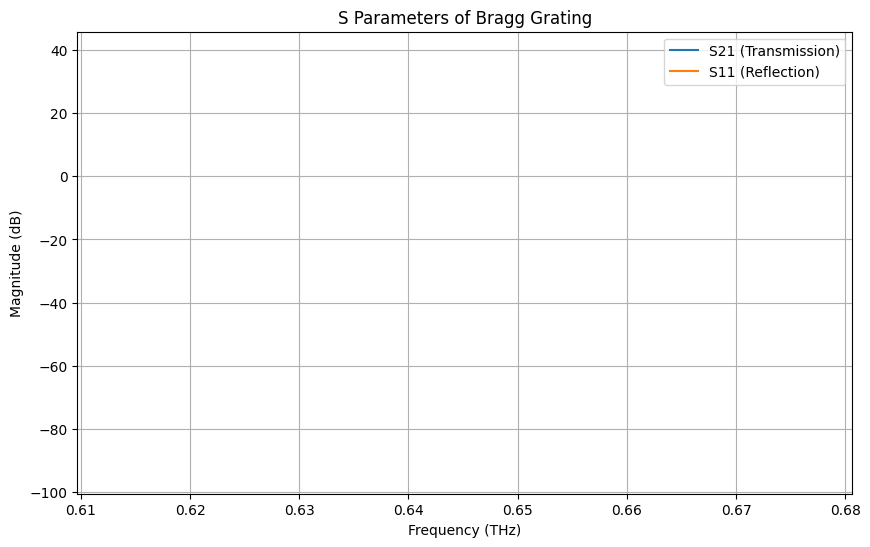

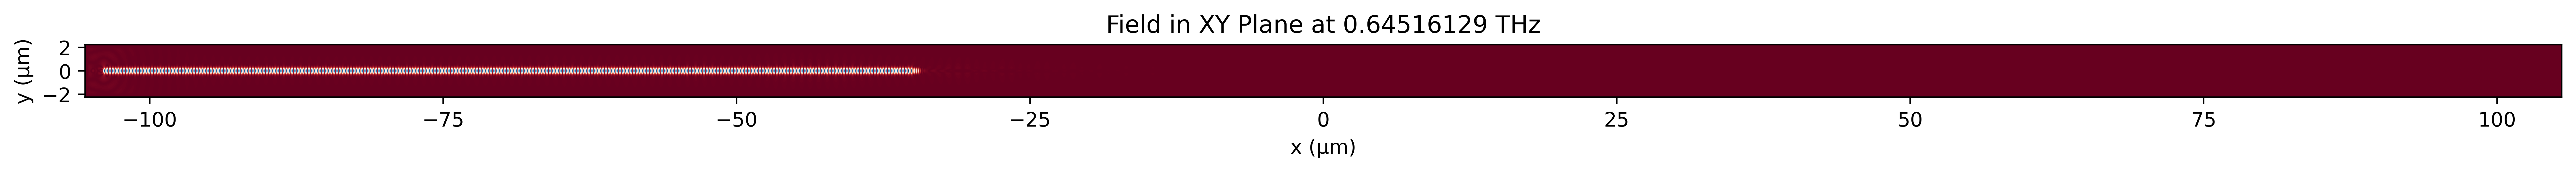

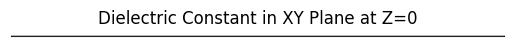

In [ ]:
# Run simulations sequentially
for f in frequencies:
    try:
        result = run_simulation(f)
        f, trans_flux, refl_flux, xy_plane = result
        transmissions.append((f, trans_flux))
        reflections.append((f, refl_flux))
        field_data.append((f, xy_plane))
    except Exception as exc:
        print(f"Frequency {f} generated an exception: {exc}")

# Convert lists to numpy arrays and sort by frequency
transmissions = np.array(sorted(transmissions, key=lambda x: x[0]))
reflections = np.array(sorted(reflections, key=lambda x: x[0]))

frequencies_sorted = transmissions[:, 0]
transmissions_sorted = transmissions[:, 1]
reflections_sorted = reflections[:, 1]

# Plotting the S parameters
plt.figure(figsize=(10, 6))
plt.plot(frequencies_sorted, 10 * np.log10(transmissions_sorted), label="S21 (Transmission)")
plt.plot(frequencies_sorted, 10 * np.log10(reflections_sorted), label="S11 (Reflection)")
plt.xlabel("Frequency (THz)")
plt.ylabel("Magnitude (dB)")
plt.title("S Parameters of Bragg Grating")
plt.legend()
plt.grid(True)
plt.show()



# Visualize the fields
for f, xy_plane in field_data:
    fig, axs = plt.subplots(1, 1, figsize=(18, 6), dpi=500)

    # Plot xy-plane
    axs.imshow(xy_plane.T, interpolation='spline36', cmap='RdBu', extent=(-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy))
    axs.set_title(f'Field in XY Plane at {f} THz')
    axs.set_xlabel('x (µm)')
    axs.set_ylabel('y (µm)')




    plt.tight_layout()
    plt.show()


# Assuming cell is defined as mp.Vector3(sx, sy, sz)
eps_data = sim.get_array(center=mp.Vector3(0,0,0), size=cell, component=mp.Dielectric)

# Plotting the xy-plane at z=0
plt.figure()
plt.imshow(eps_data[:, :].T, interpolation='spline36', cmap='binary', extent=(-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy))
plt.title('Dielectric Constant in XY Plane at Z=0')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.axis('off')
plt.show()

3D sim

In [ ]:
# Run simulations sequentially
for f in frequencies:
    try:
        result = run_simulation(f)
        f, trans_flux, refl_flux, xy_plane, xz_plane, yz_plane = result
        transmissions.append((f, trans_flux))
        reflections.append((f, refl_flux))
        field_data.append((f, xy_plane, xz_plane, yz_plane))
    except Exception as exc:
        print(f"Frequency {f} generated an exception: {exc}")

# Convert lists to numpy arrays and sort by frequency
transmissions = np.array(sorted(transmissions, key=lambda x: x[0]))
reflections = np.array(sorted(reflections, key=lambda x: x[0]))

frequencies_sorted = transmissions[:, 0]
transmissions_sorted = transmissions[:, 1]
reflections_sorted = reflections[:, 1]

# Plotting the S parameters
plt.figure(figsize=(10, 6))
plt.plot(frequencies_sorted, 10 * np.log10(transmissions_sorted), label="S21 (Transmission)")
plt.plot(frequencies_sorted, 10 * np.log10(reflections_sorted), label="S11 (Reflection)")
plt.xlabel("Frequency (THz)")
plt.ylabel("Magnitude (dB)")
plt.title("S Parameters of Bragg Grating")
plt.legend()
plt.grid(True)
plt.show()

# Visualize the fields
for f, xy_plane, xz_plane, yz_plane in field_data:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=500)

    # Plot xy-plane
    axs[0].imshow(xy_plane.T, interpolation='spline36', cmap='RdBu', extent=(-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy))
    axs[0].set_title(f'Field in XY Plane at {f} THz')
    axs[0].set_xlabel('x (µm)')
    axs[0].set_ylabel('y (µm)')


    # Plot xz-plane
    axs[1].imshow(xz_plane.T, interpolation='spline36', cmap='RdBu', extent=(-0.5*sx, 0.5*sx, -0.5*sz, 0.5*sz))
    axs[1].set_title(f'Field in XZ Plane at {f} THz')
    axs[1].set_xlabel('x (µm)')
    axs[1].set_ylabel('z (µm)')

    # Plot yz-plane
    axs[2].imshow(yz_plane.T, interpolation='spline36', cmap='RdBu', extent=(-0.5*sy, 0.5*sy, -0.5*sz, 0.5*sz))
    axs[2].set_title(f'Field in YZ Plane at {f} THz')
    axs[2].set_xlabel('y (µm)')
    axs[2].set_ylabel('z (µm)')

    plt.tight_layout()
    plt.show()


# Assuming cell is defined as mp.Vector3(sx, sy, sz)
eps_data = sim.get_array(center=mp.Vector3(0,0,0), size=cell, component=mp.Dielectric)

# Plotting the xy-plane at z=0
plt.figure()
plt.imshow(eps_data[:, :, int(sz)//2+28].T, interpolation='spline36', cmap='binary', extent=(-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy))
plt.title('Dielectric Constant in XY Plane at Z=0')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.axis('off')
plt.show()

# Plotting the xz-plane at y=0
plt.figure()
plt.imshow(eps_data[:, int(sy)//2+20, :].T, interpolation='spline36', cmap='binary', extent=(-0.5*sx, 0.5*sx, -0.5*sz, 0.5*sz))
plt.title('Dielectric Constant in XZ Plane at Y=0')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.axis('off')
plt.show()

# Plotting the yz-plane at x=0
plt.figure()
plt.imshow(eps_data[int(sx)//2, :, :].T, interpolation='spline36', cmap='binary', extent=(-0.5*sy, 0.5*sy, -0.5*sz, 0.5*sz))
plt.title('Dielectric Constant in YZ Plane at X=0')
plt.xlabel('y (µm)')
plt.ylabel('z (µm)')
plt.axis('off')
plt.show()

-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00551409 s
Working in 3D dimensions.
Computational cell is 20.2 x 3.68571 x 2.4 with resolution 35
     block, center = (-7.5,0,0)
          size (5,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,0)
          size (10,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (7.5,0,0)
          size (5,0.48,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-0.2)
          size (20,2.2,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.55,3.55,3.55)
subpixel-averaging is 88.6711% done, 0.511073 s remaining
time for set_epsilon = 12.8204 s
-----

MPB solved for frequency_1(0.78,0,0) = 0.259222 after 42 iters
MPB solved for frequency_1(1.9706,0,0) = 0.625953 after 16 iters
MPB solved for frequency_1(2.03569,0,0) = 0.645132 after 10 iters
MPB solved for frequency_1(2.03579,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.03579,0,0) = 0.645161 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=150.0)

Meep progress: 0.014285714285714285/150.0 = 0.0% done in 10.5s, 110372.2s to go
on time step 1 (time=0.0142857), 10.5075 s/step
Meep progress: 0.45714285714285713/150.0 = 0.3% done in 14.6s, 4761.3s to go
on time step 32 (time=0.457143), 0.130285 s/step
Meep progress: 0.9285714285714285/150.0 = 0.6% done in 18.6s, 2992.3s to go
on time step 65 (time=0.928571), 0.123628 s/step
Meep progress: 1.3857142857142857/150.0 = 0.9% done in 22.8s, 2441.9s to go
on time step 97 (time=1.38571), 0.128932 s/step
Meep progress: 1.8142857142857143/150.0 = 1.2% done in 26.8s, 2190.6s to go
on time step 127 (time=1.81429), 0.134948 s/step
Meep progress: 2.2857142857142856/150.0 = 1.5% done in 30.9s, 1996.9s to go
on time step 160 (time=2.28571), 0.123427 s/step
Meep progress: 2.742857142857143/150.0 = 1.8% done in 34.9s, 1873.8s to go
on time step 193 (time=2.75714), 0.126043 s/step
Meep progress: 3.157142857142857/150.0 = 2.1% done in 38.9s, 1809.6s to go
on time step 223 (time=3.18571), 0.13634 s/step


KeyboardInterrupt: 

[0.64516129]


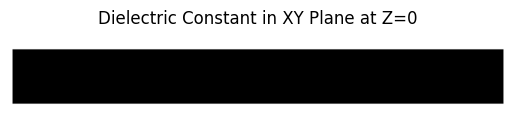

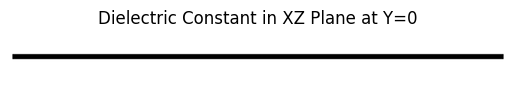

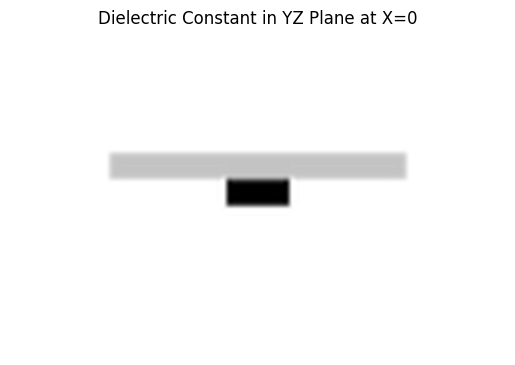

In [ ]:
# Plotting the xy-plane at z=0
print(frequencies)
plt.figure()
plt.imshow(eps_data[:, :, int(sz)//2+30].T, interpolation='spline36', cmap='binary', extent=(-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy))
plt.title('Dielectric Constant in XY Plane at Z=0')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.axis('off')
plt.show()

# Plotting the xz-plane at y=0
plt.figure()
plt.imshow(eps_data[:, int(sy)//2+20, :].T, interpolation='spline36', cmap='binary', extent=(-0.5*sx, 0.5*sx, -0.5*sz, 0.5*sz))
plt.title('Dielectric Constant in XZ Plane at Y=0')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.axis('off')
plt.show()

# Plotting the yz-plane at x=0
plt.figure()
plt.imshow(eps_data[int(sx)//2+50, :, :].T, interpolation='spline36', cmap='binary', extent=(-0.5*sy, 0.5*sy, -0.5*sz, 0.5*sz))
plt.title('Dielectric Constant in YZ Plane at X=0')
plt.xlabel('y (µm)')
plt.ylabel('z (µm)')
plt.axis('off')
plt.show()